neural_network

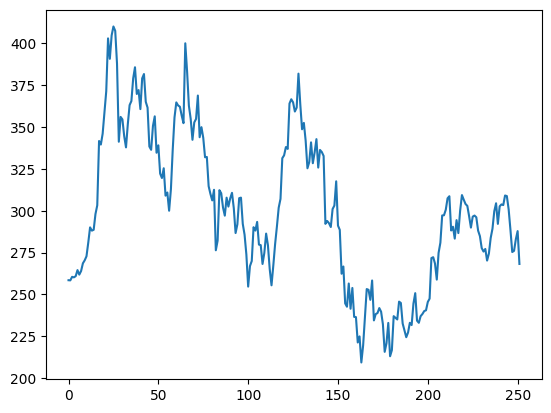

In [80]:
from pandas import read_csv
from datetime import datetime
from pandas.plotting import autocorrelation_plot
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping


# Ensure eager execution
tf.config.run_functions_eagerly(True)

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

def parser(x):
	return datetime.strptime(x,'%Y-%m-%d')

series = read_csv('data/cleaned_data_bert.csv', header=0, parse_dates=[0], index_col=0)

# Filter rows where "Stock Name" is 'TLSA'
series = series[series['Stock Name'] == 'TSLA']
series = series.drop(['Stock Name', 'Adj Close','Date'], axis=1)
series["Close"].plot()
plt.show()

# CNN + LSTM

Epoch 1/100
7/7 - 1s - 140ms/step - loss: 1.2403 - val_loss: 0.1231 - learning_rate: 5.0000e-04
Epoch 2/100
7/7 - 1s - 168ms/step - loss: 1.2209 - val_loss: 0.1211 - learning_rate: 5.0000e-04
Epoch 3/100
7/7 - 1s - 125ms/step - loss: 1.1660 - val_loss: 0.1198 - learning_rate: 5.0000e-04
Epoch 4/100
7/7 - 2s - 233ms/step - loss: 1.1291 - val_loss: 0.1140 - learning_rate: 5.0000e-04
Epoch 5/100
7/7 - 1s - 187ms/step - loss: 1.0247 - val_loss: 0.1036 - learning_rate: 5.0000e-04
Epoch 6/100
7/7 - 1s - 179ms/step - loss: 0.9130 - val_loss: 0.0935 - learning_rate: 5.0000e-04
Epoch 7/100
7/7 - 1s - 132ms/step - loss: 0.7382 - val_loss: 0.0900 - learning_rate: 5.0000e-04
Epoch 8/100
7/7 - 1s - 126ms/step - loss: 0.5273 - val_loss: 0.1046 - learning_rate: 5.0000e-04
Epoch 9/100
7/7 - 1s - 178ms/step - loss: 0.5317 - val_loss: 0.1223 - learning_rate: 5.0000e-04
Epoch 10/100
7/7 - 1s - 182ms/step - loss: 0.7465 - val_loss: 0.0976 - learning_rate: 5.0000e-04
Epoch 11/100
7/7 - 1s - 125ms/step - lo

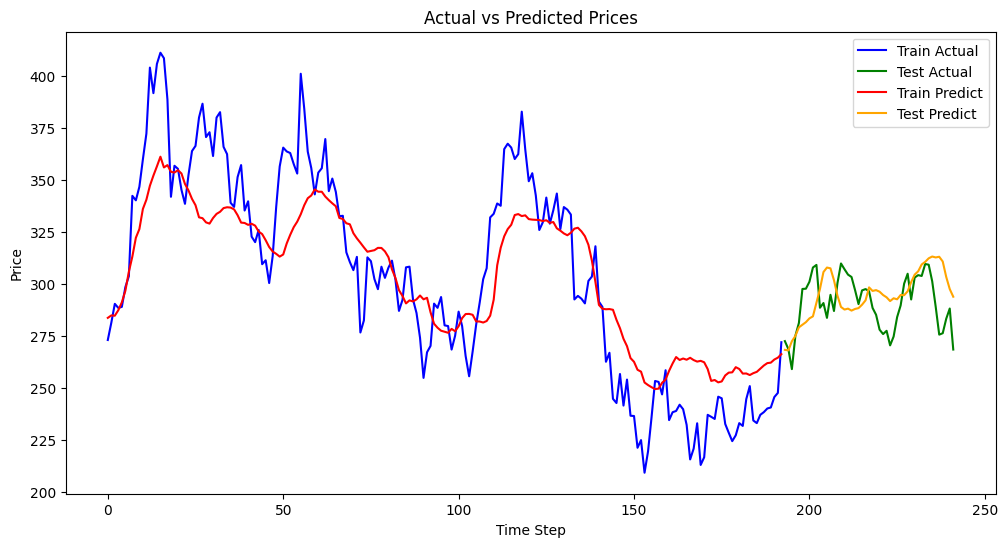

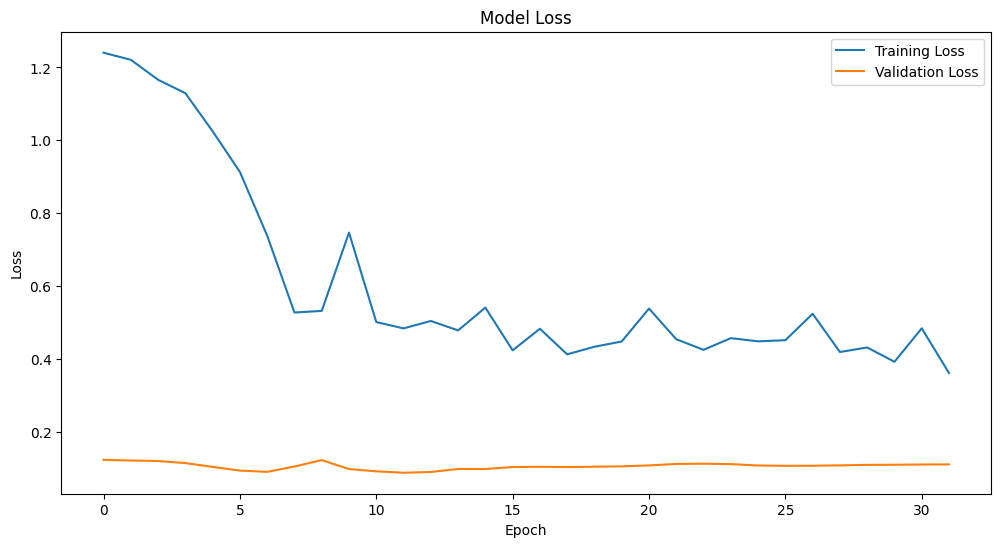

Train MSE: 651.3977033576222
Test MSE: 234.3170766615172


In [81]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scale all the features (not just 'Close')
scaler = StandardScaler()
scaled = scaler.fit_transform(series.values)  # Scale all features

# Function to create data sequences for time-series forecasting
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, :])  # Use all features
        y.append(data[i + look_back, 3])  # Predict the 'Close' price (index 3 corresponds to 'Close')
    return np.array(X), np.array(y)

# Shorter look-back window
look_back = 10

# Create dataset with the updated look_back window
X, y = create_dataset(scaled, look_back)

# Reshape X to have 3 dimensions for LSTM
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=20)

# Define model
model = Sequential()

# CNN layers for feature extraction
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

# LSTM layer
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.4))

# Dense layers
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    verbose=2,
    callbacks=[early_stop, lr_scheduler]
)


# Predict
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverse scaling for predictions (only for 'Close' column)
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], series.shape[1] - 1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], series.shape[1] - 1))), axis=1))[:, 0]

# Reverse scaling for actual values
y_train_actual = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], series.shape[1] - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], series.shape[1] - 1))), axis=1))[:, 0]

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train_actual)), y_train_actual, label='Train Actual', color='blue')
plt.plot(range(len(y_train_actual), len(y_train_actual) + len(y_test_actual)), y_test_actual, label='Test Actual', color='green')
plt.plot(range(len(train_predict)), train_predict, label='Train Predict', color='red')
plt.plot(range(len(train_predict), len(train_predict) + len(test_predict)), test_predict, label='Test Predict', color='orange')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate MSE
train_mse = mean_squared_error(y_train_actual, train_predict)
test_mse = mean_squared_error(y_test_actual, test_predict)
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')


# LSTM using sequences

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - loss: 0.1060 - val_loss: 0.0043
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - loss: 0.0215 - val_loss: 0.0069
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - loss: 0.0205 - val_loss: 0.0047
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - loss: 0.0152 - val_loss: 0.0051
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - loss: 0.0158 - val_loss: 0.0104
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - loss: 0.0173 - val_loss: 0.0047
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - loss: 0.0165 - val_loss: 0.0053
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 237ms/step - loss: 0.0129 - val_loss: 0.0094
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - loss: 0.0117 - val_loss: 0.0058
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - loss: 0.0133 - val_loss: 0.0079
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - loss: 0.0118 - val_loss: 0.0048
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2

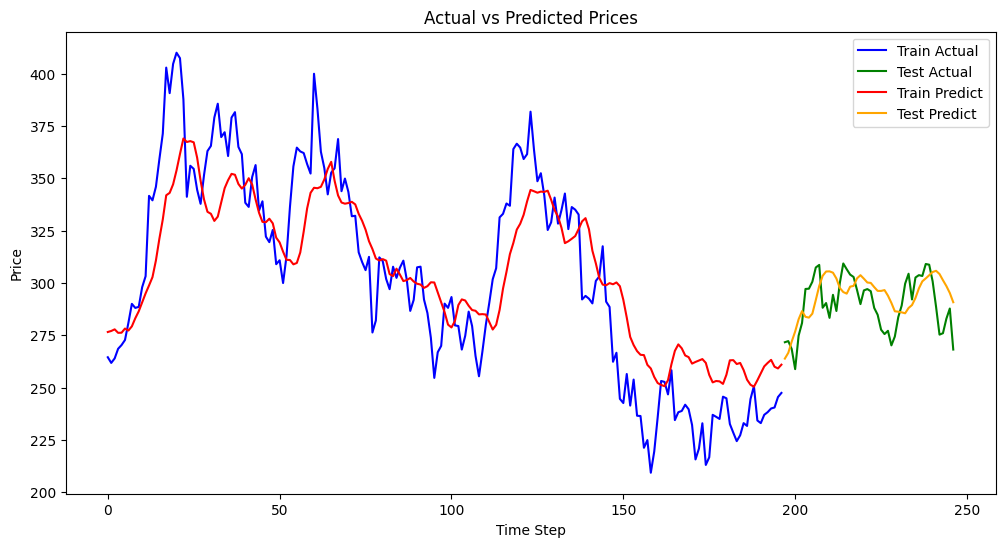

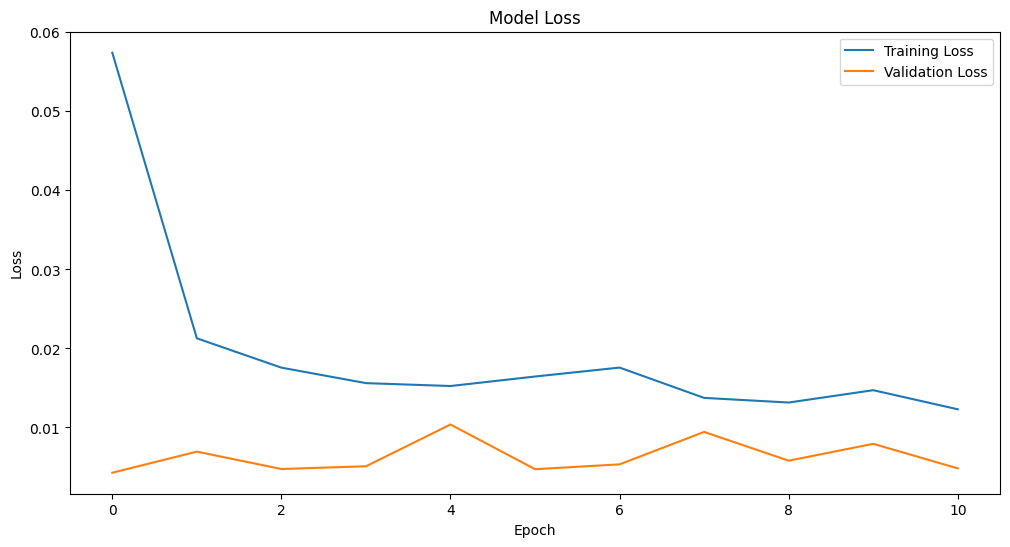

Train MSE: 655.8380909258834
Test MSE: 171.82372654628978


In [82]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

target = 'Close'

# Scale the features (X) using MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(series)

# Scale the target variable (y) using MinMaxScaler
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(series[[target]])

# Combine the scaled data to create the sequences
scaled_data = pd.DataFrame(X_scaled, columns=series.columns)
scaled_data[target] = y_scaled

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X_sequence = data.iloc[i:i+seq_length].values
        X.append(X_sequence)
        y.append(data.iloc[i + seq_length][target])
    return np.array(X), np.array(y)

# Hyperparameters
seq_length = 5  # Increased from 5 to 10

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

# Reshape X for LSTM (samples, time steps, series)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model with increased complexity
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=4,
                    validation_data=(X_test, y_test), verbose=1,
                    callbacks=[early_stopping])

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverse scaling for predictions (only for 'Close' column)
train_predict = scaler_y.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler_y.inverse_transform(test_predict.reshape(-1, 1))

# Reverse scaling for actual values
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train_actual)), y_train_actual, label='Train Actual', color='blue')
plt.plot(range(len(y_train_actual), len(y_train_actual) + len(y_test_actual)), y_test_actual, label='Test Actual', color='green')
plt.plot(range(len(train_predict)), train_predict, label='Train Predict', color='red')
plt.plot(range(len(train_predict), len(train_predict) + len(test_predict)), test_predict, label='Test Predict', color='orange')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate MSE
train_mse = mean_squared_error(y_train_actual, train_predict)
test_mse = mean_squared_error(y_test_actual, test_predict)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

# Custom Feedforward Network

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.1150 - val_loss: 0.0976
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2998 - val_loss: 0.1165
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1757 - val_loss: 0.0345
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1193 - val_loss: 0.0388
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1326 - val_loss: 0.0224
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1317 - val_loss: 0.0146
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0734 - val_loss: 0.0138
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0854 - val_loss: 0.0105
Epoch 9/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0619 - val_loss: 0.0102
Epoch 10/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0725 - val_loss: 0.0109
Epoch 11/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0675 - val_loss: 0.0096
Epoch 12/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0569 - val_loss: 0.0103
E

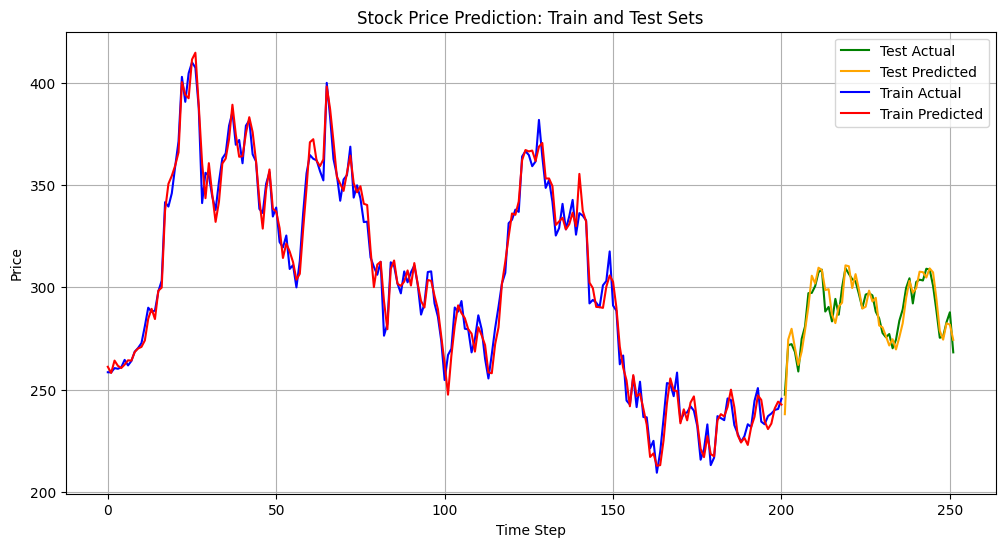

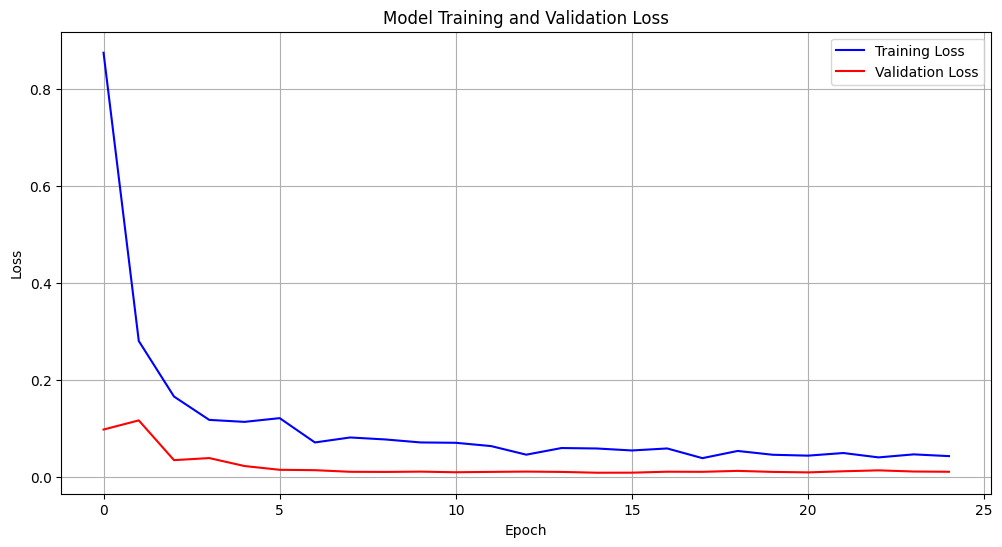

Mean Squared Error: 26.756058510450966


In [83]:
# Define the target variable (y) and the features (X)

y = series['Close']
X = series.drop(['Close'], axis=1)

# Split into train and test (80% train, 20% test)
train_size = int(len(series) * 0.8)  # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scale the features (X) using StandardScaler
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale the target variable (y) using StandardScaler
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # Reshape for compatibility
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Define the model
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=X_train_scaled.shape[1]))  # Fewer units
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=25, batch_size=32, validation_data=(X_test_scaled, y_test_scaled))

# Predict on the test data (predictions are scaled)
forecast_scaled = model.predict(X_test_scaled)

# Reshape forecast to 1D
forecast_scaled = forecast_scaled.reshape(-1)

# Inverse transform the forecast to get original scale values
forecast = scaler_y.inverse_transform(forecast_scaled.reshape(-1, 1))

# Convert y_test to numpy for consistency with forecast
y_test_dates = y_test.index.to_numpy()

# Plot the Actual vs Predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(
    range(len(y_train), len(y_train) + len(y_test)),
    y_test.values, label='Test Actual', color='green'
)  # Test Actual values
plt.plot(
    range(len(y_train), len(y_train) + len(y_test)),
    forecast, label='Test Predicted', color='orange'
)  # Test Predicted values

# Add Train Actual values to the same plot
plt.plot(
    range(len(y_train)),
    scaler_y.inverse_transform(y_train_scaled), label='Train Actual', color='blue'
)  # Train Actual values

# Add Train Predicted values to the same plot
train_pred_scaled = model.predict(X_train_scaled)
train_pred = scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1))
plt.plot(
    range(len(y_train)),
    train_pred, label='Train Predicted', color='red'
)  # Train Predicted values

# Titles and legends
plt.title('Stock Price Prediction: Train and Test Sets')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Training and Validation Loss Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, forecast)
print(f'Mean Squared Error: {mse}')
